In [3]:
using CSV,DataFrames,Plots,LaTeXStrings,Statistics

In [4]:
# data of FRB181112 includes MW and another intergalaxy (102+85) = 187
frbs = CSV.read("frbs.csv",header = 1, delim = ",",ignorerepeated=true,DataFrame)


,name,redshift,DM_obs,err_DM_obs,DM_MW,optional
,String15,Float64,Float64,Int64,Float64,Int64
1,FRB180916,0.0337,348.8,1,199.0,1
2,FRB190608,0.1178,338.7,5,37.2,1
3,FRB121102,0.19273,558.0,3,188.0,0
4,FRB190102,0.291,363.6,3,57.3,0
5,FRB180924,0.3214,361.42,6,40.5,0
6,FRB190611,0.378,321.4,2,57.8,1
7,FRB181112,0.4755,589.27,3,187.0,0
8,FRB190711,0.522,593.1,4,56.4,0
9,FRB190523,0.66,760.8,6,37.0,0


### Calculation of DM_LSS, DM_host, and DM_theor

In [12]:
function likelihood(z,Δz,DM,H0_all,Ωb_h2,Ωm_h2)
    n = length(z)
    sigma = zeros(n)
    L = zeros(n)
    L_total = zeros(length(H0_all))
    for i in 1:length(H0_all)  
        for j in 1:n
            sigma[j] = sigma_without_MW(z[j])
            L[j] = (1/sqrt(2*pi*sigma[j]^2))*exp(-(DM[j]-DM_theor(z[j],Δz,H0_all[i],Ωb_h2,Ωm_h2))^2/(2*sigma[j]^2))
        end
        L_total[i] = prod(L[j] for j in 1:n)
    end
    return L_total
end

function sigma_without_MW(z)
    return sqrt((50 / (1 + z))^2 + (40 + 140 * z)^2) # pc/cm^3
end
function DM_host(z)
    return 100/(1+z) # pc/cm^3
end

function DM_theor(z,Δz,H0, Ωb_h2, Ωm_h2)
    return (DM_LSS(z,Δz,H0, Ωb_h2, Ωm_h2) + DM_host(z)) # pc/cm^3     
end

function sigma_with_MW(z)
    return sqrt(30^2 + (50/(1+z))^2 + (40 + 140*z)^2) # pc/cm^3
end

function DM_LSS(z,Δz,H0,Ωb_h2,Ωm_h2)
    # constants
    G = 6.67408e-11 
    c = 299792458
    m_p = 1.6726219e-27
    pc = 3.0856775814914E+18
    Mpc = 3.0856775814914E+22 
    
    #parameters
    χ_e = 0.88
    fIGM = 0.84
    #H0 = 100*h (km/s/Mpc) used to replace H0 in given eqn

    z_sample = collect(0:Δz:z)
    Ez_sample = zeros(length(z_sample))

    for i in 1:length(z_sample)
        Ez_sample[i] = sqrt(Ωm_h2*(1 + z_sample[i])^3 + ((H0/100)^2-Ωm_h2))
    end
    prefactor = χ_e*fIGM*300*c*Ωb_h2/(8*pi*m_p*G)
    DMLSS =  prefactor*sum(((1 + z_sample[i])/Ez_sample[i])*Δz for i in 1:length(z_sample)) # pc/m
    return (1E-5)*DMLSS/(pc^2) # factor 1E-5/pc^2 used to get prefactor in pc/cm^3

end

function H0_error(Lik_all,H0_max,H0_all)
    sum1 = 0
    for i in 1:length(Lik_all)
        sum1 = sum1 + Lik_all[i]*(H0_all[i]-H0_max)^2/sum(Lik_all)        
    end
    return sqrt(sum1)
end

H0_error (generic function with 1 method)

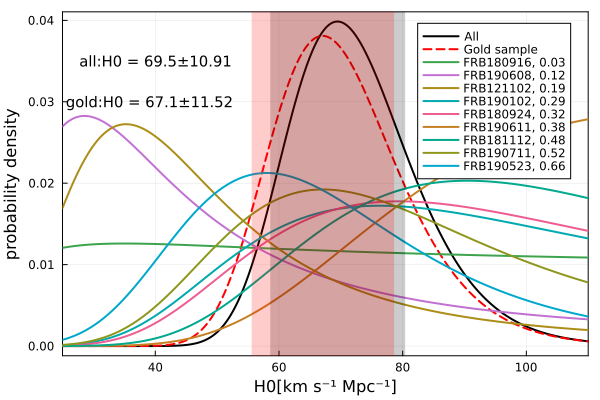

In [15]:
# All FRBS
DM_all = frbs.DM_obs - frbs.DM_MW
z_all = frbs.redshift
ΔH0 = 0.1
H0_all = collect(25:ΔH0:110)
# initial parameters
Ωb_h2 = 0.02237
Ωm_h2 = 0.143
Δz = 0.0001
Lik_all = likelihood(z_all,Δz,DM_all,H0_all,Ωb_h2,Ωm_h2)
Lik_all = Lik_all/sum(Lik_all*ΔH0)
plot(framestyle = :box,xlims=(25,110),legend=:topright)
plot!(H0_all, Lik_all, xlabel="H0[km s⁻¹ Mpc⁻¹]", ylabel="probability density", label="All", color=:black, linewidth=2)
H0_all_max = H0_all[argmax(Lik_all)]
H0_all_err = H0_error(Lik_all,H0_all_max,H0_all)
annotate!(40, 0.035, text("all:H0 = $(round(H0_all_max,digits=3))±$(round(H0_all_err, digits=2))", 10, :black))

# Gold Sample
DM_gold = frbs.DM_obs[frbs.optional.==0] - frbs.DM_MW[frbs.optional.==0]
z_gold = frbs.redshift[frbs.optional.==0]
Lik_gold = likelihood(z_gold,Δz,DM_gold,H0_all,Ωb_h2,Ωm_h2)
Lik_gold = Lik_gold/sum(Lik_gold*ΔH0)
plot!(H0_all, Lik_gold, label="Gold sample", color=:red, linewidth=2, linestyle=:dash)
H0_gold_max = H0_all[argmax(Lik_gold)]
H0_gold_err = H0_error(Lik_gold,H0_gold_max,H0_all)

# individual FRBs
for i in 1:length(z_all)
    DM_i = frbs.DM_obs[i] - frbs.DM_MW[i]
    z_i = frbs.redshift[i]
    Lik_i = likelihood(z_i,Δz,DM_i,H0_all,Ωb_h2,Ωm_h2)
    Lik_i = Lik_i/sum(Lik_i*ΔH0)
    z_i = round(z_i,digits=2)
    plot!(H0_all, Lik_i, label="$(frbs.name[i]), $z_i",lw=2)
end

plot!([H0_all_max - H0_all_err, H0_all_max + H0_all_err], seriestype=:vspan, alpha=0.2, color=:black, label="")
plot!([H0_gold_max - H0_gold_err, H0_gold_max + H0_gold_err], seriestype=:vspan, alpha=0.2, color=:red, label="")
annotate!(39, 0.03, text("gold:H0 = $(round(H0_gold_max,digits=3))±$(round(H0_gold_err, digits=2))", 10, :black))


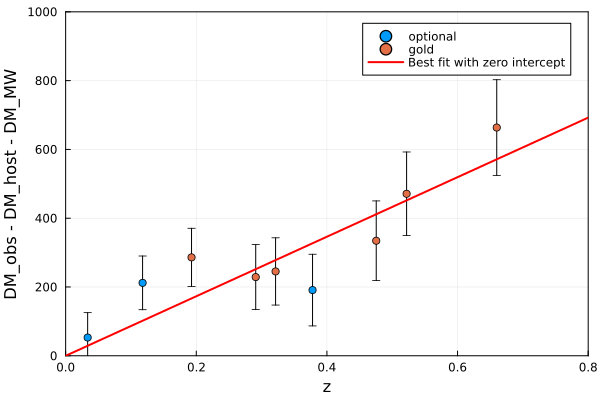

In [7]:
# Best-fit between DM_LSS and redshift(z) 
function Least_Squares_Fitting(x_data, y_data, sig_y_data)
    n = length(x_data)
    Y = zeros(n)
    A = ones(n) # for incept to be zero
    C = zeros(n,n)
    for i in 1:n
        Y[i] = y_data[i]
        A[i] = x_data[i]
        C[i,i] = sig_y_data[i]^2
    end

    # best fit
    bestfit = inv(transpose(A)*inv(C)*A)*(transpose(A)*inv(C)*Y)
    slope = bestfit[1]
    intercept = 0.0 # 0.0 taken for without bias
    return slope, intercept
end
# redshift and DM data
z_data = frbs.redshift
DM_host_data = DM_host.(z_data)
DM_data = frbs.DM_obs - frbs.DM_MW - DM_host_data
sig_y_data = sigma_with_MW.(z_data)

slope, intercept = Least_Squares_Fitting(z_data, DM_data, sig_y_data)
plot_lines = plot(framestyle = :box,legend=:topright)

z_gold = []
z_opt = []
DM_gold = []
DM_opt = []
sig_y_opt = []
sig_y_gold = []
for i in 1:length(z_data)
        if (i == 1 || i == 2 || i == 6)
            push!(z_opt,z_data[i])
            push!(DM_opt,DM_data[i])
            push!(sig_y_opt,sig_y_data[i])

        else
            push!(z_gold,z_data[i])
            push!(DM_gold,DM_data[i])
            push!(sig_y_gold,sig_y_data[i])

        end
end
plot_lines = plot!(z_opt, DM_opt, yerr = sig_y_opt, seriestype=:scatter, label="optional", xlabel="z", ylabel="DM_obs - DM_host - DM_MW")
plot_lines = plot!(z_gold, DM_gold, yerr = sig_y_gold, seriestype=:scatter, label="gold", xlabel="z", ylabel="DM_obs - DM_host - DM_MW")

plot_lines = plot!(z -> slope*z+intercept,0,0.8, label="Best fit with zero intercept", color=:red, linewidth=2)
xlims!(0, 0.8)
ylims!(0, 1000)
plot(plot_lines)
